# Merian Part 2: images and Sersic fitting

**Prerequisites**
- Need to install `photutils` and `statmorph`
- Finished the Photometric Redshift notebook and Merian Part 1 notebook

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord

# We can beautify our plots by changing the matpltlib setting a little
plt.rcParams['font.size'] = 18
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.linewidth'] = 2

In [2]:
required_packages = ['statmorph', 'photutils', 'sep']  # Define the required packages for this notebook

import sys
import subprocess

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Download utils.py
    !wget -q -O /content/utils.py https://raw.githubusercontent.com/AstroJacobLi/ObsAstGreene/refs/heads/main/book/docs/utils.py
    # Function to check and install missing packages
    def install_packages(packages):
        for package in packages:
            try:
                __import__(package)
            except ImportError:
                print(f"Installing {package}...")
                subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
    # Install any missing packages
    install_packages(required_packages)
else:
    # If not in Colab, adjust the path for local development
    sys.path.append('/Users/jiaxuanl/Dropbox/Courses/ObsAstGreene/book/docs/')

# Get the directory right
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/')
  os.chdir('/content/drive/Shareddrives/AST207/data')
else:
    os.chdir('../../_static/ObsAstroData/')

In [3]:
from utils import pad_psf, show_image

## 1: Enjoy Merian images!

We've been playing with catalogs so far. But the Merian images are truly amazing! In this part, let's take a look at those images and try to make a color-composite image by combining the Hyper Suprime-Cam (HSC) data with Merian. 

The Merian (and the corresponding HSC) images for objects in the Merian redshift range are made available in class's google drive. 

In [77]:
cat_inband = Table.read('./merian/cosmos_Merian_DR1_specz_inband.fits')
print('Total number of galaxies:', len(cat_inband))

Total number of galaxies: 152


In [78]:
cutout_dir = "./merian/cutouts/"

In [79]:
from astropy.io import fits
i = 9 # the 9th object in the catalog
obj = cat_inband[i]
coord = SkyCoord(obj['coord_ra_Merian'], obj['coord_dec_Merian'], unit='deg')
name = obj['name']
print('Name:', name)

# Open images and psfs
cutouts = {band: fits.open(os.path.join(cutout_dir, "hsc", f"{name}_HSC-{band}.fits"))[1].data for band in ['g', 'r', 'i', 'z']}
cutouts['N708'] = fits.open(os.path.join(cutout_dir, "merian", f"{name}_N708_merim.fits"))[1].data

Name: J095828.56+013901.69


We use the function `show_image` to display the data:

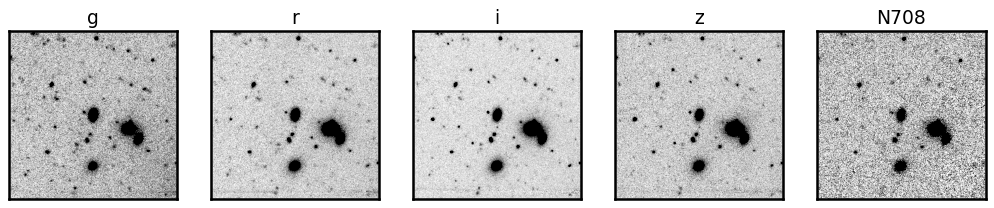

In [80]:
percl = 98 # this changes the contrast and dynamic range of the display

fig, axes = plt.subplots(1, 5, figsize=(14, 3))
for i, band in enumerate(cutouts.keys()):
    show_image(cutouts[band], fig=fig, ax=axes[i], cmap='Greys', percl=percl)
    axes[i].set_title(band, fontsize=15)

**Exercise 1**

Change the `percl` parameter from 92 to 99.9, and comment on how that changes the look of the galaxy. If you are interested in the low-surface-brightness features, should you tune `percl` low or high?

In [81]:
## your answer

Black & White images are cool but a bit boring... Let's make them colorful! Here we use the method in [Lupton et al. (2004)](https://ui.adsabs.harvard.edu/abs/2004PASP..116..133L/abstract), featuring our own [Robert Lupton](https://web.astro.princeton.edu/people/robert-lupton)! 

Text(0, 1.02, 'g')

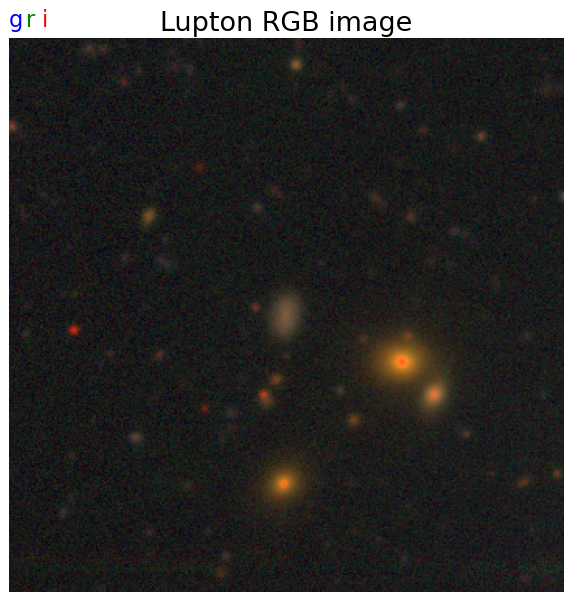

In [82]:
from astropy.visualization import make_lupton_rgb
rgb = make_lupton_rgb(cutouts['i'], cutouts['r'], cutouts['g'], stretch=1, Q=10, minimum=-0.1)
plt.figure(figsize=(8, 8))
plt.imshow(rgb, origin='lower')
plt.axis('off')

ax = plt.gca()
plt.title('Lupton RGB image')
plt.text(0.06, 1.02, 'i', transform=ax.transAxes, color='red')
plt.text(0.03, 1.02, 'r', transform=ax.transAxes, color='green')
plt.text(0, 1.02, 'g', transform=ax.transAxes, color='blue')

**Exercise 2**

1. There are three parameters in the `lupton_rgb` function: `stretch`, `Q`, and `minimum`. Try to play with these parameters, and find a combination that makes the most beautiful color image.

2. Randomly pick 5 more galaxies, and plot their color images. 

In [83]:
## your answer

## 2: Sersic fitting

A galaxy's light distribution is often described by a [Sersic](https://en.wikipedia.org/wiki/S%C3%A9rsic_profile) model. For a comprehensive introduction to the Sersic model, see [this paper](https://arxiv.org/abs/astro-ph/0503176). Here let's try to fit a Sersic model to the Merian galaxies. 

**Note**: For HSC and Merian images below, the zeropoint is always 27.0 mag, and the pixel scale is always 0.168 arcsec/pixel.

In [84]:
import statmorph
from astropy.convolution import convolve_fft
from utils import get_img_central_region
from astropy.io import fits

In [85]:
i = 9
obj = cat_inband[i]
coord = SkyCoord(obj['coord_ra_Merian'], obj['coord_dec_Merian'], unit='deg')
name = obj['name']
print('Name:', name)

# Open images and psfs
cutouts = {band: fits.open(os.path.join(cutout_dir, "hsc", f"{name}_HSC-{band}.fits"))[1].data for band in ['g', 'r', 'i', 'z']}
cutouts['N708'] = fits.open(os.path.join(cutout_dir, "merian", f"{name}_N708_merim.fits"))[1].data

cutout_headers = {band: fits.open(os.path.join(cutout_dir, "hsc", f"{name}_HSC-{band}.fits"))[1].header for band in ['g', 'r', 'i', 'z']}
cutout_headers['N708'] = fits.open(os.path.join(cutout_dir, "merian", f"{name}_N708_merim.fits"))[1].header

psfs = {band: fits.open(os.path.join(cutout_dir, "hsc", f"{name}_HSC-{band}_psf.fits"))[0].data for band in ['g', 'r', 'i', 'z']}
psfs['N708'] = fits.open(os.path.join(cutout_dir, "merian", f"{name}_N708_merpsf.fits"))[0].data

# We only include the central region (150 x 150 pix) of the bigger image
# This makes the fitting faster
band = 'i'
imgs = get_img_central_region(cutouts, 150)
img = imgs[band]
psf = psfs[band]

Name: J095828.56+013901.69


Let's take a look at this galaxy first

(-0.5, 149.5, -0.5, 149.5)

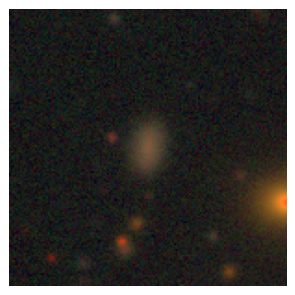

In [86]:
from astropy.visualization import make_lupton_rgb
rgb = make_lupton_rgb(imgs['i'], imgs['r'], imgs['g'], stretch=1, Q=10, minimum=-0.1)
plt.figure(figsize=(4, 4))
plt.imshow(rgb, origin='lower')
plt.axis('off')

We first need to detect the "footprint" of the galaxy that we are interested in, and we need to construct a mask to block out the light from other sources. We do it step by step:
1. We construct a background model to estimate the background noise level. Both source detection and Sersic fitting need the background noise level. Sersic fitting needs it to calculate the chi-square, which is the objective function to be optimized. We need chi-square to find the best-fit Sersic model. 
2. We detect sources that are 4 sigma above the background noise level. The sources will include the target galaxy and other galaxies in this image.
3. We then keep the central galaxy, and make a mask to block out other sources. We also need a "segmentation map" for the central galaxy to indicate its footprint.

We use a software called [`sep`](https://sep.readthedocs.io/en/stable/index.html) to do the above things. 

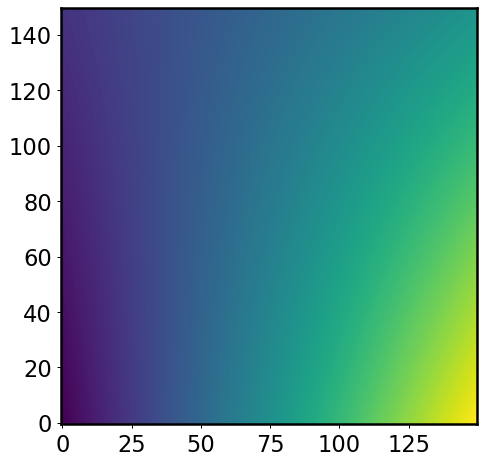

In [87]:
import sep
img = np.array(img).astype(img.dtype.newbyteorder('='))
bkg = sep.Background(img, bw=128, bh=128) # this makes the background model

# you can visualize the background noise level using the following
plt.imshow(bkg.rms())
# we need this background noise to detect sources above a certain level

This `bkg` object contains important information about the background, including the rms of the background level. This is exactly what we need.

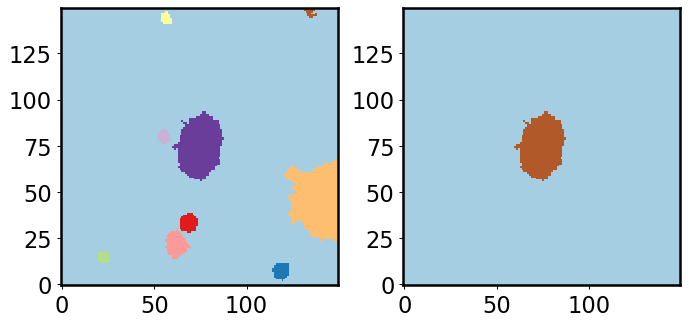

In [88]:
# We extract sources above 4-sigma
_, segmap = sep.extract(img, 4, err=bkg.rms(), deblend_cont=0.005, segmentation_map=True)

# The segmentation map indicates the footprint of each source. 
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9, 4))
ax1.imshow(segmap, origin='lower', cmap='Paired', interpolation='none')

# we only keep the footprint of the target galaxy 
ind = segmap[img.shape[1]//2, img.shape[0]//2]
obj_segmap = segmap.copy()
obj_segmap[obj_segmap != ind] = 0

ax2.imshow(obj_segmap, origin='lower', cmap='Paired', interpolation='none')

In the left panel, we show the "segmentation map" for all sources above $4\sigma$. Many sources are detected. However, we only want the central one, so we use `segmap.keep_label(ind)`. The right panel shows the segmentation map after this step. This segmentation map will be used in the Sersic fitting.

<Axes: >

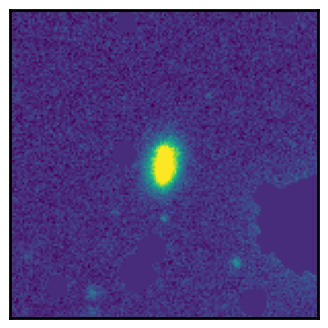

In [89]:
# We construct a mask based on the original segmap. The mask blocks out
segmap[segmap == ind] = 0
mask = (segmap > 0)
from astropy.convolution import convolve_fft, Gaussian2DKernel
mask = convolve_fft(mask, Gaussian2DKernel(1))
mask = mask > 1e-2

show_image(img * ~mask, figsize=(4, 4), percl=99.5)

The image above shows the **masked** image. The target galaxy is kept, and other sources are masked. Some faint tiny sources are still there, but they won't affect the Sersic fitting.

Now it's time to do Sersic fitting! We use a package called `statmorph`. It also provides many other measurements. See [its documentation](https://statmorph.readthedocs.io/en/latest/) for details.

In [90]:
source_morphs = statmorph.source_morphology(
  img, obj_segmap, weightmap=bkg.rms(), psf=psf, mask=mask)
morph = source_morphs[0]

That's it! Let's visualize the results:

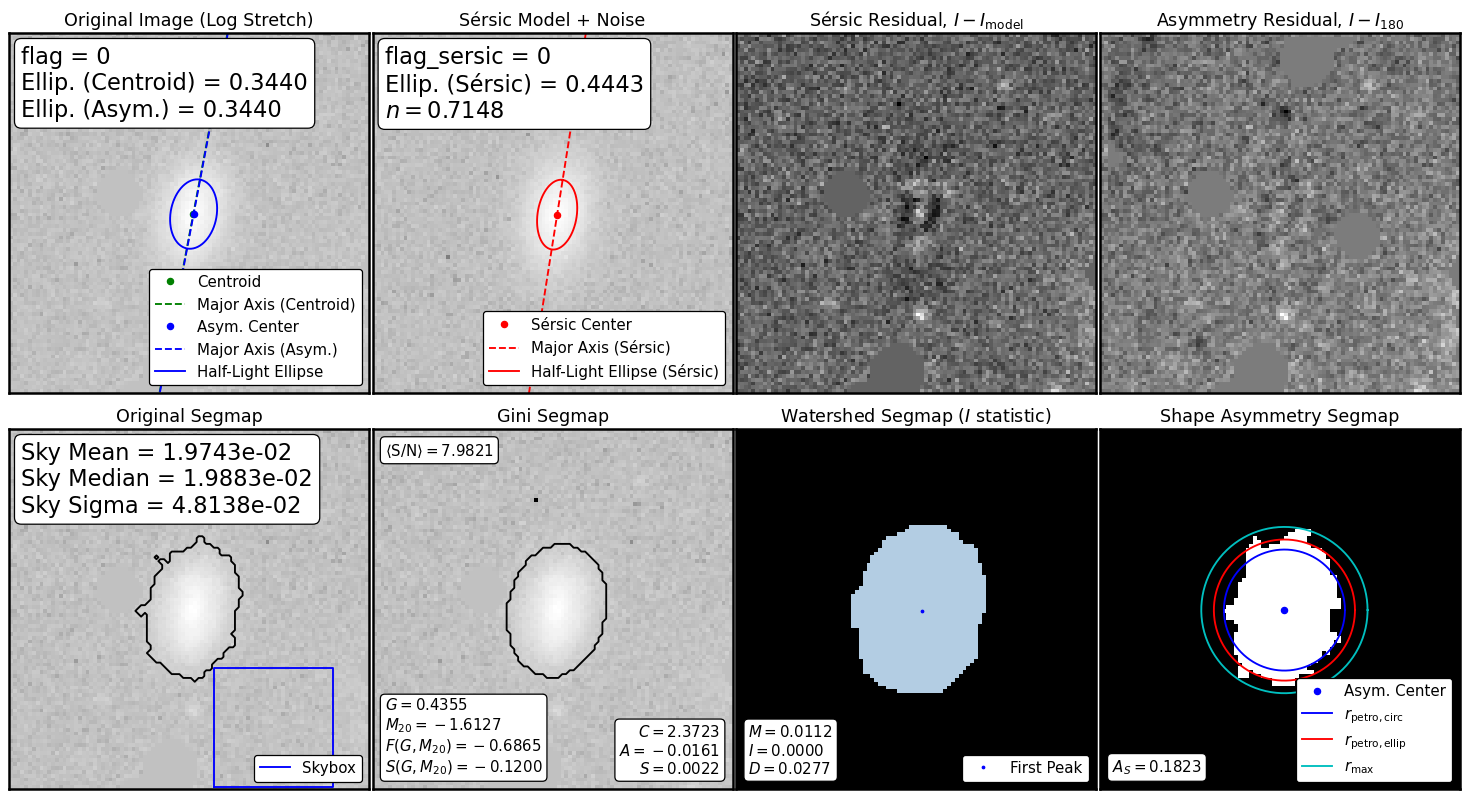

In [91]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)

We see lots of information on this plot! For Sersic fitting, we should only focus on the first three panels. The first panel shows the original image, the second shows the best-fit Sersic model, and the third shows the residual. Overall, the fit is pretty good (also indicated by `flag_sersic = 0`)! The residual for this galaxy is very smooth. However, for other galaxies, there will be some structures not captured by the Sersic model. Sersic model is not perfect, but it's useful. It gives you a rough idea of the size and luminosity of the galaxy.

Let's check the best-fit parameters, such as the half-light radius, ellipticity, etc. 
In this way, we can measure the properties of many more galaxies.

In [64]:
print('Half light radius:', morph.sersic_rhalf)
print('Ellipticity:', morph.sersic_ellip)
print('Sersic index:', morph.sersic_n)
print('Sersic amplitude:', morph.sersic_amplitude)

Half light radius: 9.192740796290797
Ellipticity: 0.4442891808030815
Sersic index: 0.714847078700199
Sersic amplitude: 0.7144324349610914


You can use the following function to calculate the total magnitude of the best-fit Sersic model.

In [65]:
def calc_mtot(morph, zpt=27.0, pixscale=0.168):
    # based on https://arxiv.org/abs/astro-ph/0503176
    from scipy.special import gammaincinv, gamma
    b_n = gammaincinv(2. * morph.sersic_n, 0.5)
    f_n = gamma(2*morph.sersic_n)*morph.sersic_n*np.exp(b_n)/b_n**(2*morph.sersic_n)
    mu_e = zpt - 2.5*np.log10(morph.sersic_amplitude/pixscale**2)
    mu_e_ave = mu_e - 2.5*np.log10(f_n)
    r_circ = morph.sersic_rhalf * np.sqrt(1 - morph.sersic_ellip)
    A_eff = np.pi*(r_circ * pixscale)**2
    m_tot = mu_e_ave - 2.5*np.log10(2*A_eff)
    return m_tot

In [66]:
print(f'Total magnitude in the {band} band:', calc_mtot(morph))

Total magnitude in the i band: 20.6440834393367


**Exercise 3**

Repeat this Sersic fitting for a few other galaxies, and make sure it works for most of them. Also try it in other bands, such as `g, r, N708`.


In [ ]:
## your answer

**Exercise 4**

1. For this galaxy `refID=10` and `Name: J095828.56+013901.69`, write a function to calculate its physical half-light size using the half-light radius from Sersic fit and its spec-z. Express the physical size of this galaxy in `kpc`.

   Remember that the angular size (in arcsec) and the physical size (in kpc) are related, using a formula we discussed in class. There is a package called `astropy.cosmology` that will allow you to convert between the redshift that we observe from the spectrum and the "angular diameter distance" in Mpc. For example, we can use the `Planck15` cosmology to calculate the distance for $z=0.1$:
    ```python
    from astropy.cosmology import Planck15
    Planck15.angular_diameter_distance(0.1)
    ```

2. For all galaxies in our sample, do Sersic fitting, then extract their physical sizes. Make a scatter plot for their sizes and absolute magnitude. 

In [ ]:
## your answer